In [2]:
import pandas as pd

xlsfile = 'trainingData.xlsx'
tprtlist = ['tprt_1','tprt_2','tprt_3','tprt_4','tprt_5','tprt_6']
loadlist = ['load_1','load_2','load_3','load_4','load_5','load_6']
names = ['models', 'locations'] + tprtlist + loadlist + ['months', 'hours', 'label']

data_0 = pd.io.excel.read_excel(xlsfile, sheetName='Sheet1', names=names).dropna()

In [24]:
models = set(data_0.models) # {u'FocusAX', u'I210+', u'I210+C'}
models = sorted(model) # {u'FocusAX', u'I210+', u'I210+C'}
for m in models:
    data_0[m] = [m == meter for meter in data_0.models]
data_0[models].sum()

FocusAX     826
I210+      2124
I210+C     1484
dtype: int64

In [27]:
locations = set(data_0.locations)
locations = sorted(locations)
for l in locations:
    data_0[l] = [l == loc for loc in data_0.locations]
data_0[locations].sum()

B       36
H       36
I       12
IR      12
LS      35
M       24
O     1813
OE     121
ON      48
OP      30
OR     351
OS    1448
OW     387
OY      12
RS      34
U       23
W       12
dtype: int64

In [29]:
months = set(data_0.months)
months = sorted(months)
for m in months:
    data_0[m] = [m == m1 for m1 in data_0.months]
data_0[months].sum()

Apr    375
Aug    389
Dec    349
Feb    371
Jan    364
Jul    382
Jun    382
Mar    375
May    376
Nov    306
Oct    373
Sep    392
dtype: int64

In [32]:
mkeys = [1,2,3]
mvals = models

In [4]:
from sklearn.decomposition import PCA, KernelPCA
import numpy as np
import matplotlib.pyplot as plt

def do_pca(d, n):
    pca = PCA(n_components=n, copy=True)
    x_pca = pca.fit_transform(d)
    print pca.explained_variance_ratio_
    return x_pca

def do_kernel_pca(d, n):
    kpca = KernelPCA(n_components=n, kernel='rbf', fit_inverse_transform=True, gamma=0.1)
    x_kpca = kpca.fit_transform(d)
    return x_kpca

def draw(df, title):
    colors = ['#5cb85c', '#c9302c']
    flags = ['good', 'bad']
    plt.figure()
    plt.title(title)
    for flag, color in zip(flags, colors):
        mask = df['label'] == flag
        plt.scatter(df[mask]['x'], df[mask]['y'], c=color, label=flag)
    plt.legend()
    
x = data_0[tprtlist].values
y = data_0['label'].values
print x.shape, x.nbytes

x_pca = do_pca(x, 2)
df_pca = pd.DataFrame({'x': x_pca[:, 0], 'y': x_pca[:, 1], 'label': np.where(y == 1, 'bad', 'good')})
draw(df_pca, 'PCA')

# x_kpca = do_kernel_pca(x, 2)
# df_kpca = pd.DataFrame({'x': x_kpca[:, 0], 'y': x_kpca[:, 1], 'label': np.where(y == 1, 'bad', 'good')})
# draw(df_kpca, 'KernelPCA')

 (4434, 6) 212832
[ 0.81208804  0.05856851]


0.886384129847


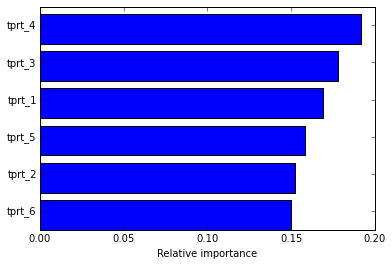

In [93]:
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

x_pca_train, x_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y)
x_train, x_test, y_train, y_test = train_test_split(x, y)

gbdt = GradientBoostingClassifier(n_estimators=400, learning_rate=0.1, max_depth=5, random_state=1234)
gbdt.fit(x_train, y_train)
print gbdt.score(x_test, y_test)
df = pd.crosstab(y_test, gbdt.predict(x_test), rownames=['Actual'], colnames=['Predicted'])

indices = np.argsort(gbdt.feature_importances_)
plt.figure()
plt.barh(np.arange(len(tprtlist)), gbdt.feature_importances_[indices])
plt.yticks(np.arange(len(tprtlist))+0.5, np.array(tprtlist)[indices])
plt.xlabel('Relative importance')

/opt/anaconda/envs/np18py27-1.9/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


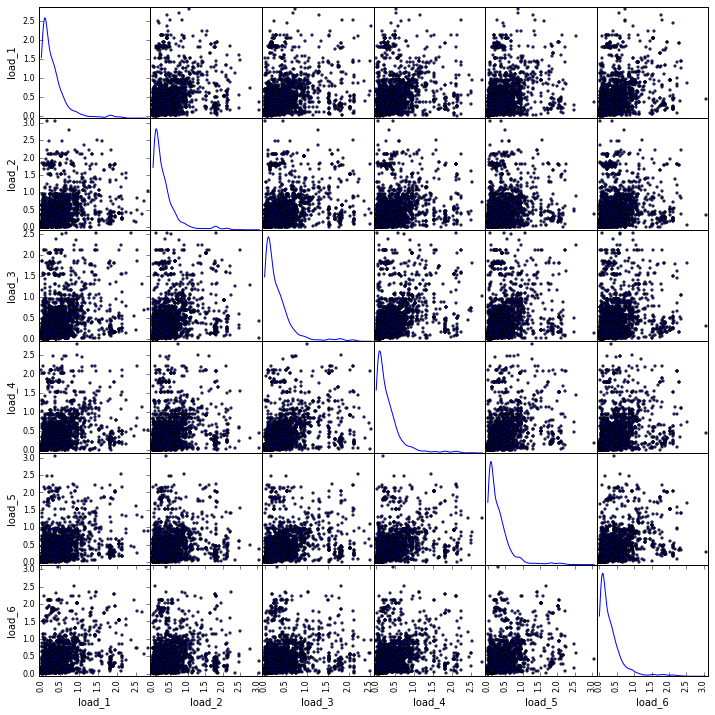

In [3]:
from pandas.tools.plotting import scatter_matrix

# analyz data
smaller_frame = data_0[loadlist]#tprtlist+loadlist
axeslist = scatter_matrix(smaller_frame, alpha=0.8, figsize=(12,12), diagonal="kde")
for ax in axeslist.flatten():
   ax.grid(False)